# From Statistical Physics to Data-Driven Modelling with Applications to Quantitative Biology
Tutorial 5 : Analysis of Protein Sequence Data to infer protein structure. 

This Tutorial is based on the work:

Faruck Morcos, Andrea Pagnani, Bryan Lunt, Arianna Bertolino, Debora S Marks, Chris Sander, Riccardo Zecchina, Jose  Onuchic, Terence Hwa, and Martin Weigt. Direct-coupling analysis of residue coevolution captures native contacts across many protein families. Proceedings of the National Academy of Sciences, 108(49):E1293–E1301, 2011.

For a review  of Direct Coupling Analysis see: 
Simona Cocco, Christoph Feinauer, Matteo Figliuzzi, Remi Monasson, and Martin Weigt. Inverse statistical physics of protein sequences: a key issues review. Reports on Progress in Physics, 81(3):032601, 2018.

This tutorial is long but can be split in two parts: Question 9 can be treated in a following tutirial.

Solution Notebook SC RM FZ.

In [47]:

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
#%matplotlib inline
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams["figure.figsize"] = (10, 8)
#plt.rcParams["font.size"] = 26

import numpy.linalg as LA
from numpy.linalg import inv

Useful functions for the tutorial.

In [5]:
# Function to convert the amino acids letters into integer numbers from 0 to 20
def letter2number(a): 
    
    switcher = {
        '-': 0,
        'A': 1,
        'C': 2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
        'I':8,
        'K':9,
        'L':10,
        'M':11,
        'N':12,
        'P':13,
        'Q':14,
        'R':15,
        'S':16,
        'T':17,
        'V':18,
        'W':19,
        'Y':20,     
    }
    #return switcher.get(a, "nothing")
    return switcher.get(a,0)

In [6]:
# Function transform the Couplings in zero sum gauge and  Compute the Frobenius Norm
def Frobenius(J):
    F=np.zeros((L,L))
    Fv=np.zeros(Np)
    ind=np.zeros((Np,2)).astype(int)
    indv=np.zeros((L,L)).astype(int)
    l=0
    for i in range (L):
        for j in range(i+1,L):
            #matrix  21x21 including also the gauge symbol
            jinf2=np.zeros((q+1,q+1))
            jinf2[0:q,0:q]=J[i*q:(i+1)*q,j*q:(j+1)*q]
            #zero-sum matrix
            #J_norm=np.transpose(np.transpose(jinf2 - np.mean(jinf2,0))
            #                     - np.mean(jinf2,1)) + np.mean(jinf2)
            J_norm=jinf2 - np.mean(jinf2,0)
            J_norm=J_norm - np.mean(J_norm,1,keepdims=True)
            #Frobenius norm
            F[i,j] = LA.norm(J_norm)
            F[j,i]=F[i,j]
            ind[l,0]=i
            ind[l,1]=j
            Fv[l]=F[i,j]
            indv[i,j]=l
            l=l+1        
    return [Fv,indv,F,ind]

In [20]:
#Function to compute the Positive Predictive Value of predicted contacts when ranking pairs of contacts 
#in decreasing order of their Frobenious Norms and comparing with residues distances on the real structure 5PTI
#(downloaded from PDB data base)

def ppv(Finput,indv,ind):
    #Sort Finput in reverse order 
    Fsort=np.sort(Finput)[::-1]
    Fsort_index=np.argsort(Finput)[::-1]

    #Read structural Distances
    backmap_distances=np.loadtxt('../Data/backmap_distances_e_PF00014.txt')
    distv=np.ones(Np)*50;
    lb=np.size(backmap_distances,0)
    dist=np.zeros((L,L))
    for l in range (lb):
        i=int(backmap_distances[l,0]-1)
        j=int(backmap_distances[l,1]-1)
        dist[i,j]=backmap_distances[l,4]
        leff=indv[i,j]
        distv[leff]=backmap_distances[l,4]

    #Positive Predicted Value for all contacts 
    sux=np.zeros(Np+1)
    suxn=np.zeros(Np+1)
    #2 residues are defined as in contact when their distances <= 8 Angstrom in the  cristallographic structure
    dc2=8;
    sux[0]=0
    for i in range (Np):
        if distv[Fsort_index[i]]<dc2:
            sux[i+1]=sux[i]+1
        else:
            sux[i+1]=sux[i]
        suxn[i+1]=sux[i+1]/(i+1)

    #Positive Predicted Value for contacts distant along the backbone i-j>4
    sud=np.zeros(Np+1)
    sudn=np.zeros(Np+1)
    dc2=8
    sud[0]=0
    ni=0
    for i in range (Np):
        if ind[Fsort_index[i],1]-ind[Fsort_index[i],0] >4:
            if distv[Fsort_index[i]]<dc2:
                        sud[ni+1]=sud[ni]+1
            else:
                        sud[ni+1]=sud[ni]  
            sudn[ni+1]=sud[ni+1]/(ni+1)
            ni=ni+1
    return [suxn,sudn]
    

In [33]:
#Function to apply the Average Product Correction to the Frobenious Norm of the couplings
def Apc(F):
    #Average Product Correction which improves contact Predictions
    Fapc=np.zeros(Np)
    avcoupl1=np.sum(F,1)/L
    sumj=np.sum(avcoupl1)/L
    l=0
    for i in range (L):
        for j in range (i+1,L):
            Fapc[l]=F[i,j]-avcoupl1[i]*avcoupl1[j]/sumj
            l=l+1         
    return Fapc           

Question 1: Read the Data: PF0014 sequences form PFAM (2013). 

In [21]:
# Open the file and write in "seqs" a list containing all lines
data=open('../Data/seqPF14.txt', 'r')
# readlines read all lines in the file in the variable "seqs".
seqs = data.readlines()

data.close()

In [ ]:
#Show data
#seqs[0][:]

Question 2: Convert the MSA alphabet from letters to numbers 0...20.

In [22]:
#Extract M and L and convert the MSA in a numerical matrix
M=np.size(seqs)
L=len(seqs[0])-1
Np=int(L*(L-1)/2)
print( 'Number of Sequences in the MSA M:',M,'Number of Residues in the sequence L:', L)
align=np.zeros((M,L)).astype(int)
for m in range (M):
    for i in range (L):
        align[m,i]=letter2number(seqs[m][i])  

Number of Sequences in the MSA M: 2143 Number of Residues in the sequence L: 53


Question 3: One Hot Encoding of  the alignment in a binary (M,20xL) array.

In [23]:
#Expand the alignment in a bynary (M,20xL) array
#gauge last a.a. remove the last symbol
q=20
msa20=np.zeros((M,L*q))#.astype(int)  commented to go faster in the calculation of p2


for i in range(L):
    for a in range (q):
        msa20[:,i*q+a]=(align[:,i]==a)
#Alternative Way
#for m in range(M):
#    for i in range(L):
#        if (align[m,i]!=20):
#            msa20[m,i*q+align[m,i]]=1    
        


In [ ]:
#Show alignmrnt in 1 hot encoding
#msa20[0,0:19]

Question 4: Extract from the data the frequencies and connected correlations. 

In [24]:
#p = frequence of amino acid  on site i
p=np.sum(msa20,0)/M
#p2=pairwise frequency
p2=np.dot(msa20.T,msa20)/M
#cr=covariance
cr=p2-np.outer(p,p)

Question 5: Add a pseudocount to regularize the data.

In [25]:
#Pseudocount alfa=0.5
alfa=0.5;
pa=(1-alfa)*p+alfa/21.
p2a=(1-alfa)*p2+alfa/(21*21)
#Fix the conservation constraints in the diagonal blocks
for i in range (L):
    p2a[i*q:(i+1)*q,i*q:(i+1)*q]=0
    for a in range (q):
        p2a[i*q+a,i*q+a]=pa[i*q+a]
#Regularized connected correlation matrix
cra=p2a-np.outer(pa,pa)


and Invert the Covariance matrix to obtain the Coupling Matrix. 

In [26]:
#Coupling Matrix
jcoupl=-inv(cra)

Question 6: Compute the Frobenious Norm to estimate the couplings strength for each pair of residues.

In [27]:
[Fv,indv,F,ind]=Frobenius(jcoupl)

 Question 7: Plot the positive predictive value (PPV) for the contact predictions for all pairs of resudues and distant pairs along the sequence (i-j>4).

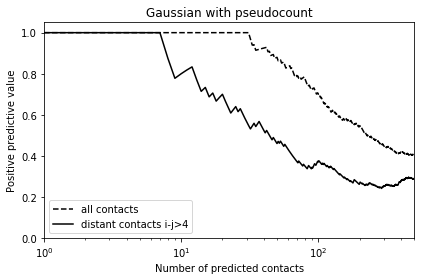

In [35]:
#Positive Predicted Value
[y1,y2]=ppv(Fv,indv,ind)

#Plot the positive predicted value
#plt.figure(figsize=(11, 6))
x=np.arange(Np+1)
c1,=plt.plot(x,y1,'k--',label='all contacts')
c2,=plt.plot(x,y2,'k',label='distant contacts i-j>4')
plt.xscale('log')
# Now add the legend with some customizations.
plt.legend (handles=[c1,c2],loc=3)
#= ax.legend(loc='upper center', shadow=True)
#plt.legend('Location','southwest')
plt.xlim([1,500])
plt.ylim([0,1.05])
plt.title("Gaussian with pseudocount")
plt.xlabel("Number of predicted contacts")
plt.ylabel("Positive predictive value")
#plt.text(3e2, 0.95, 'A', fontweight='bold')
plt.tight_layout()
#plt.savefig('PPVgaussall.pdf')
plt.show()

Question 8: Apply the Average Product Correction to the Frobenious Norm of the Couplings and plot the PPV for nearby and distant pairs.

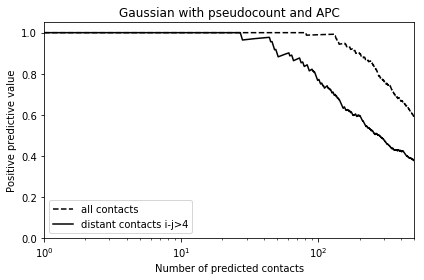

In [37]:
#Average Product Correction which improves contact Predictions
Fapc=Apc(F)

[y1,y2]=ppv(Fapc,indv,ind)
#Plot The True Positive Rate
#plt.figure(figsize=(11, 6))
x=np.arange(Np+1)
c1,=plt.plot(x,y1,'k--',label='all contacts')
c2,=plt.plot(x,y2,'k',label='distant contacts i-j>4')
plt.xscale('log')
# Now add the legend with some customizations.
plt.legend (handles=[c1,c2],loc=3)
#= ax.legend(loc='upper center', shadow=True)
#plt.legend('Location','southwest')
plt.xlim([1,500])
plt.ylim([0,1.05])
plt.title("Gaussian with pseudocount and APC")
plt.xlabel("Number of predicted contacts")
plt.ylabel("Positive predictive value")
#plt.text(3e2, 0.95, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('PPVgaussallAPC.pdf')
plt.show()


Question 10 (Bonus): Rank the contact directly from the Mutual Information, with the Average Product Correction, between the occurrences of two amino acids in sites i and j, obtained directly from the MSA and plot the PPV for contact prediction.

In [48]:
#Estimate contact directly from the mutual information
MI=np.zeros((L,L))
for i in range (L):
    for j in range (i+1,L):
        p2ap=p2a[i*q:(i+1)*q,j*q:(j+1)*q]
        pai=pa[i*q:(i+1)*q]
        paj=pa[j*q:(j+1)*q]
        paiaj=np.outer(pai,paj)
        pratio=p2ap/paiaj
        lpratio=np.log(pratio)
        MI[i,j]=np.sum(p2ap*lpratio)
        
#Average Product Correction which improves contact Predictions
Miapc=Apc(MI)


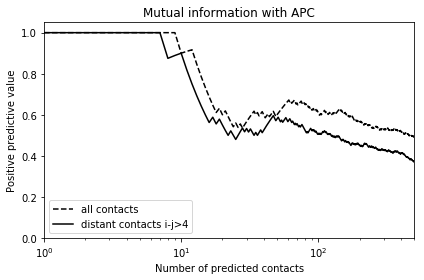

In [49]:
[y1,y2]=ppv(Miapc,indv,ind)
#Plot The True Positive Rate
#plt.figure(figsize=(11, 6))
x=np.arange(Np+1)
c1,=plt.plot(x,y1,'k--',label='all contacts')
c2,=plt.plot(x,y2,'k',label='distant contacts i-j>4')
plt.xscale('log')
# Now add the legend with some customizations.
plt.legend (handles=[c1,c2],loc=3)
#= ax.legend(loc='upper center', shadow=True)
#plt.legend('Location','southwest')
plt.xlim([1,500])
plt.ylim([0,1.05])
plt.title("Mutual information with APC")
plt.xlabel("Number of predicted contacts")
plt.ylabel("Positive predictive value")
plt.tight_layout()
#plt.savefig('PPVMIAPC.pdf')
plt.show()


# Part 2. Question 9A: Implement the Graphical Lasso Algorithm and use it to infer  the couplings.

In [56]:
#function cdlasso : Coordinate Descent required by Graphical Lasso
#finds minimum of 1/2 beta x beta - beta y + gamma |beta| with tolerance eps
def cdlasso(x,y,gamma,eps):
    nn=np.size(y)
    diffla=eps+1.
    beta=np.zeros(nn)
    while (diffla > eps):        
        betacopy=np.copy(beta)  
        for j in range (nn):
            beta[j]=0
            xv=x[j,:]
            vvar=y[j]-np.dot(xv,beta)
            if (abs(vvar)>gamma): 
                beta[j]=(vvar-np.sign(vvar)*gamma)/(x[j,j])
        diffla=max(abs(beta-betacopy));    
    return beta

def graphlasso(correl,gamma): 
    #routine Graphical Lasso: finds sparse interactions in Gaussian theory
    # Friedman, Hastie, Tibshirani, Biostatistics 9, 432-441 (2008)
    # correl = correlation matrix
    # gamma = strength of L1 penalty
    nn=np.size(correl,0)
    w=np.copy(correl+gamma*np.eye(nn))
    elediag=np.diag(correl+gamma*np.eye(nn));
    eps=.001;
    diff2=eps+1;
    while (abs(diff2) > eps):
        wcopy=np.copy(w)
        for j in range(nn):
        #remove column and row number j from w
            rem=np.concatenate((np.eye(j,nn),np.rot90(np.eye(nn-j-1,nn),2)), axis=0)
            wr= np.dot(np.dot(rem,w),rem.T)
            g0=np.dot(rem,correl[:,j])
            #compute solution to Lasso problem using coordinate descent    
            w0=np.dot(wr,cdlasso(wr,g0,gamma,eps))
            # insert back column and row into w
            #w=np.dot(rem.T,np.dot(w11,rem))
            w[:,j]=np.dot(rem.T,w0)
            w[j,:]=np.dot(w0.T,rem)
            w[j,j]=elediag[j]
        # check convergence condition
        diff2=np.max(np.max(abs(w-wcopy)))
    winv=inv(w);
    #%diff2=trace(winv*correl)-nn+gamma*sum(sum(abs(winv)));
    return winv    

# Graphical lasso from SKlearn, corrected because:
# The algorithm employed to solve this problem is the GLasso algorithm, 
# from the Friedman 2008 Biostatistics paper. It is the same algorithm as in the R glasso package.
# Note: One possible difference with the glasso R package is that the diagonal coefficients are not penalized.
# We have to correct for this difference
# note: graph_lasso has been renamed graphical_lasso from v0.20 of sklearn

#from sklearn.covariance import graph_lasso #for <v0.20
#from sklearn.covariance import graphical_lasso #for >v0.20
#def graphlasso_sklearn(correl,gamma): 
#    [w, winv] = graphical_lasso(correl,gamma);
#    w = w + gamma*np.eye(np.size(w,0));
#    winv=inv(w);
#    return winv


In [58]:
#Covariance matrix with graphical lasso - test
Atest=np.array([[2.,2.,3.],
   [2.,6.,6.],
   [3.,6.,10.]])
Btest=graphlasso(Atest,0.1)
print(Btest)
#Btest=graphlasso_sklearn(Atest,0.1)
#print(Btest)

[[ 0.79935673 -0.06212249 -0.1932695 ]
 [-0.06212249  0.38169356 -0.2051292 ]
 [-0.1932695  -0.2051292   0.27434089]]


Fix  the regularization strength gamma to the expected optimal value and infer couplings.

In [59]:
#run graphical lasso (this is a bit slow)
mygamma=np.sqrt(np.log(q*L)/M)
print(mygamma)
GLjcoupl = - graphlasso(cr,mygamma)

0.05701398583690484


Question 9B: Compare Frobenious Norm of Gaussian couplings with GLasso couplings.

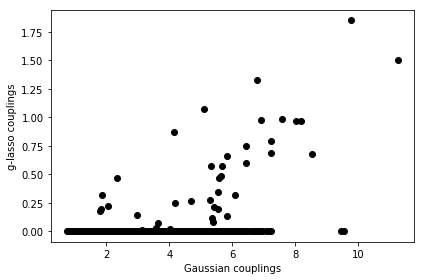

In [60]:
#compare Frobenious Norm for Gaussian couplings with GLasso couplings 
[GLFv,GLindv,GLF,GLind]=Frobenius(GLjcoupl)
plt.plot(Fv,GLFv,'ko')
plt.xlabel("Gaussian couplings")
plt.ylabel("g-lasso couplings")
plt.tight_layout()
#plt.savefig('Gaussian_vs_GLasso.pdf')
plt.show()

Question 9C: Plot the positive predictive value (PPV) with Glasso  for the contact predictions for all pairs of resudues and distant pairs along the sequence (i-j>4).

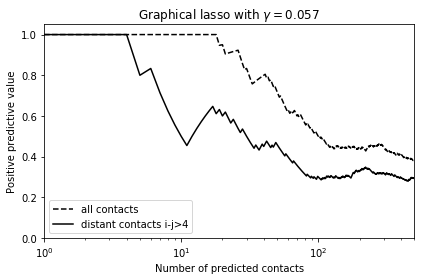

In [63]:
#Positive Predicted Value
[y1,y2]=ppv(GLFv,GLindv,GLind)

#Plot the positive predicted value
#plt.figure(figsize=(11, 6))
x=np.arange(Np+1)
c1,=plt.plot(x,y1,'k--',label='all contacts')
c2,=plt.plot(x,y2,'k',label='distant contacts i-j>4')
plt.xscale('log')
# Now add the legend with some customizations.
plt.legend (handles=[c1,c2],loc=3)
#= ax.legend(loc='upper center', shadow=True)
#plt.legend('Location','southwest')
plt.xlim([1,500])
plt.ylim([0,1.05])
plt.title("Graphical lasso with $\gamma=0.057$")
plt.xlabel("Number of predicted contacts")
plt.ylabel("Positive predictive value")
#plt.text(3e2, 0.95, 'A', fontweight='bold')
plt.tight_layout()
#plt.savefig('PPVlassoall-lambda0057.pdf')
plt.show()

Question 9D: Apply the Average Product Correction to the Frobenious Norm of the Glasso Couplings and plot the PPV for nearby and distant pairs.

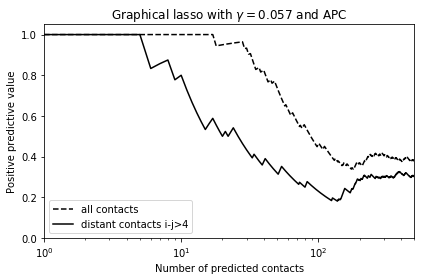

In [64]:
#Average Product Correction which improves contact Predictions
GLFapc=Apc(GLF)

[y1,y2]=ppv(GLFapc,indv,ind)
#Plot The True Positive Rate
#plt.figure(figsize=(11, 6))
x=np.arange(Np+1)
c1,=plt.plot(x,y1,'k--',label='all contacts')
c2,=plt.plot(x,y2,'k',label='distant contacts i-j>4')
plt.xscale('log')
# Now add the legend with some customizations.
plt.legend (handles=[c1,c2],loc=3)
#= ax.legend(loc='upper center', shadow=True)
#plt.legend('Location','southwest')
plt.xlim([1,500])
plt.ylim([0,1.05])
plt.title("Graphical lasso with $\gamma=0.057$ and APC")
plt.xlabel("Number of predicted contacts")
plt.ylabel("Positive predictive value")
#plt.text(3e2, 0.95, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('PPVlassoallAPC-lambda0057.pdf')
plt.show()
